# 第3部　基本的な時系列予測の手法

## 第4章　指数平滑化法とその周辺

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

# 基本関数
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

# 予測
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# 予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, MeanAbsoluteError,
    mean_absolute_percentage_error, mean_absolute_error
)

# 予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter, ForecastingGridSearchCV
)
from sktime.forecasting.model_evaluation import evaluate

# データの変換
from sktime.transformations.series.boxcox import LogTransformer

# パイプライン
from sktime.forecasting.compose import (
    TransformedTargetForecaster, MultiplexForecaster,
    EnsembleForecaster, AutoEnsembleForecaster
)
from sktime.transformations.compose import OptionalPassthrough

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset('AirPassengers').data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(
    start='1949-01', periods=len(air_passengers), freq='M')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [4]:
# データの分割
train, test = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh = np.arange(1, len(test) + 1)

### 単純指数平滑化法

In [5]:
data = pd.Series([1, 2, 3])
data

0    1
1    2
2    3
dtype: int64

In [6]:
# 平滑化定数
alpha = 0.8

# データの数だけ繰り返す
alpha_list = np.tile(1 - alpha, len(data))
alpha_list

array([0.2, 0.2, 0.2])

In [7]:
# データにかける重み
weight = alpha_list ** np.arange(0, len(data)) * alpha
weight

array([0.8  , 0.16 , 0.032])

In [8]:
# 逆順にする
weight = weight[::-1]

# 指数平滑化法による予測値
print(f'4時点目の予測値 {np.sum(data * weight):.4g} ')

4時点目の予測値 2.752 


In [9]:
# データの並び順の変更
data_2 = pd.Series([3, 2, 1])

# 指数平滑化法による予測値
print(f'4時点目の予測値 {np.sum(data_2 * weight):.4g} ')

4時点目の予測値 1.216 


In [10]:
# 参考：単なるデータの平均
np.mean(data)

2.0

### 単純指数平滑化法の再帰的表現

#### 初期値を0にした場合の単純指数平滑化法

In [11]:
# 初期値
yhat1 = 0

# 予測値の計算
yhat2 = alpha * data[0] + (1 - alpha) * yhat1
yhat3 = alpha * data[1] + (1 - alpha) * yhat2
yhat4 = alpha * data[2] + (1 - alpha) * yhat3

# 結果の確認
print(f'2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}')

2時点目 0.8 | 3時点目 1.76 | 4時点目 2.752


#### 初期データを初期値にした場合の単純指数平滑化法

In [12]:
# 初期値
yhat1 = data[0]

# 予測値の計算
yhat2 = alpha * data[0] + (1 - alpha) * yhat1
yhat3 = alpha * data[1] + (1 - alpha) * yhat2
yhat4 = alpha * data[2] + (1 - alpha) * yhat3

# 結果の確認
print(f'2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}')

2時点目 1 | 3時点目 1.8 | 4時点目 2.76


### 単純指数平滑化法の効率的な実装

#### pandasの利用

In [13]:
# 単純指数平滑化法の実施
ewma_pd = data.ewm(alpha = 0.8, adjust=False)
ewma_pd.mean()

0    1.00
1    1.80
2    2.76
dtype: float64

#### statsmodelsの利用

In [14]:
# 初期値0の場合
ewma_sm = tsa.SimpleExpSmoothing(
    data, initialization_method='known', initial_level=0
).fit(smoothing_level=0.8,optimized=False)

# 当てはめ値
ewma_sm.fittedvalues

0    0.00
1    0.80
2    1.76
dtype: float64

In [15]:
# 予測値
ewma_sm.forecast(1)

3    2.752
dtype: float64

In [16]:
# 初期データを初期値にした場合
ewma_sm_lh = tsa.SimpleExpSmoothing(
    data, initialization_method='legacy-heuristic'
).fit(smoothing_level=0.8,optimized=False)

# 当てはめ値
ewma_sm_lh.fittedvalues

0    1.0
1    1.0
2    1.8
dtype: float64

In [17]:
# 予測値
ewma_sm_lh.forecast(1)

3    2.76
dtype: float64

#### パラメータの推定

In [18]:
# 初期データと平滑化定数を推定した場合
ewma_best = tsa.SimpleExpSmoothing(
    data, initialization_method='estimated').fit()

# 当てはめ値
ewma_best.fittedvalues

0    1.0
1    1.0
2    2.0
dtype: float64

In [19]:
# 予測値
ewma_best.forecast(1)

3    3.0
dtype: float64

In [20]:
ewma_best.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1.0000000252217502,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt法

#### Holt法の実装

In [21]:
# 平滑化定数
alpha = 0.8
beta = 0.5

# 初期値
l0 = 0
d0 = 0
yhat1 = l0 + d0

# 予測値の計算
l1 = alpha * data[0]   + (1 - alpha) * (l0 + d0)
d1 = beta  * (l1 - l0) + (1 - beta)  * d0
yhat2 = l1 + d1

l2 = alpha * data[1]   + (1 - alpha) * (l1 + d1)
d2 = beta  * (l2 - l1) + (1 - beta)  * d1
yhat3 = l2 + d2

l3 = alpha * data[2]   + (1 - alpha) * (l2 + d2)
d3 = beta  * (l3 - l2) + (1 - beta)  * d2
yhat4 = l3 + d3

# 結果の確認
print(f'yhat：2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}')
print(f'level：1時点目 {l1:.3g} | 2時点目 {l2:.3g} | 3時点目 {l3:.4g}')
print(f'trend：1時点目 {d1:.3g} | 2時点目 {d2:.3g} | 3時点目 {d3:.4g}')

yhat：2時点目 1.2 | 3時点目 2.56 | 4時点目 3.808
level：1時点目 0.8 | 2時点目 1.84 | 3時点目 2.912
trend：1時点目 0.4 | 2時点目 0.72 | 3時点目 0.896


#### statsmodelsの利用

In [22]:
# holt法の実装：パラメータ固定の場合
holt = tsa.Holt(
    data, initialization_method='known', initial_level=0, initial_trend=0
).fit(smoothing_level=0.8, smoothing_trend=0.5, optimized=False)

In [23]:
# 参考：当てはめ値
holt.fittedvalues

0    0.00
1    1.20
2    2.56
dtype: float64

In [24]:
# 参考：水準成分
holt.level

0    0.800
1    1.840
2    2.912
dtype: float64

In [25]:
# 参考：ドリフト成分
holt.trend

0    0.400
1    0.720
2    0.896
dtype: float64

In [26]:
# 参考：予測値
holt.forecast(1)

3    3.808
dtype: float64

#### パラメータの推定

In [27]:
# holt法の実装：パラメータを推定した場合
holt_best = tsa.Holt(data, initialization_method='estimated').fit()
holt_best.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 2.7105053908240827e-17,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': -7.607667228101689e-05,
 'initial_trend': 1.00011499468019,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [28]:
# 参考：当てはめ値
holt_best.fittedvalues

0    1.000039
1    2.000115
2    3.000115
dtype: float64

In [29]:
# 予測値
holt_best.forecast(1)

3    4.000115
dtype: float64

### damped trendの利用

#### 減衰しないトレンドを用いた予測

In [30]:
# 増減量は一定
holt.forecast(3).diff()

3      NaN
4    0.896
5    0.896
dtype: float64

#### damped trendを想定した予測

In [31]:
# トレンドの減衰率のパラメータ
phi = 0.9

# 初期の予測値
yhat1 = l0 + phi * d0

# 予測値の計算
l1 = alpha * data[0]   + (1 - alpha) * (l0 + phi * d0)
d1 = beta  * (l1 - l0) + (1 - beta)  * phi * d0
yhat2 = l1 + phi * d1

l2 = alpha * data[1]   + (1 - alpha) * (l1 + phi * d1)
d2 = beta  * (l2 - l1) + (1 - beta)  * phi * d1
yhat3 = l2 + phi * d2

l3 = alpha * data[2]   + (1 - alpha) * (l2 + phi * d2)
d3 = beta  * (l3 - l2) + (1 - beta)  * phi * d2
yhat4 = l3 + phi * d3

# 結果の確認
print(f'yhat：2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}')
print(f'level：1時点目 {l1:.3g} | 2時点目 {l2:.3g} | 3時点目 {l3:.4g}')
print(f'trend：1時点目 {d1:.3g} | 2時点目 {d2:.3g} | 3時点目 {d3:.4g}')

yhat：2時点目 1.16 | 3時点目 2.458 | 4時点目 3.65
level：1時点目 0.8 | 2時点目 1.83 | 3時点目 2.892
trend：1時点目 0.4 | 2時点目 0.696 | 3時点目 0.843


In [32]:
# damped trendを利用した場合
holt_damped = tsa.Holt(
    data, initialization_method='known', initial_level=0, 
    initial_trend=0, damped_trend=True
).fit(smoothing_level=0.8, smoothing_trend=0.5, damping_trend=0.9, 
      optimized=False)

In [33]:
# 参考：当てはめ値
holt_damped.fittedvalues

0    0.0000
1    1.1600
2    2.4584
dtype: float64

In [34]:
# 参考：予測値
holt_damped.forecast(3)

3    3.650416
4    4.333278
5    4.947855
dtype: float64

In [35]:
# 増減量が変わる
holt_damped.forecast(3).diff()

3         NaN
4    0.682862
5    0.614576
dtype: float64

In [36]:
print(f'2時点先予測の増減量： {d3 * phi ** 2:.6g}')
print(f'3時点先予測の増減量： {d3 * phi ** 3:.6g}')

2時点先予測の増減量： 0.682862
3時点先予測の増減量： 0.614576


### Holt-winters法

#### Holt-Winters法の実装

In [37]:
# 平滑化定数
alpha = 0.8
beta = 0.5
gamma = 0.6

# 初期値
l0 = 0
d0 = 0
s_ng1 = 0 # -1時点目
s0 = 0    # 0時点目
yhat1 = l0 + d0 + s_ng1 # 周期2なので、前の時点のsを使う

# 予測値の計算
l1 = alpha * (data[0] - s_ng1)   + (1 - alpha) * (l0 + d0)
d1 = beta  * (l1 - l0)           + (1 - beta)  * d0
s1 = gamma * (data[0] - l0 - d0) + (1 - gamma) * s_ng1
yhat2 = l1 + d1 + s0   # 周期2なので、前の時点のsを使う

l2 = alpha * (data[1] - s0)      + (1 - alpha) * (l1 + d1)
d2 = beta  * (l2 - l1)           + (1 - beta)  * d1
s2 = gamma * (data[1] - l1 - d1) + (1 - gamma) * s0
yhat3 = l2 + d2 + s1   # 周期2なので、前の時点のsを使う

l3 = alpha * (data[2] - s1)      + (1 - alpha) * (l2 + d2)
d3 = beta  * (l3 - l2)           + (1 - beta)  * d2
s3 = gamma * (data[2] - l2 - d2) + (1 - gamma) * s1
yhat4 = l3 + d3 + s2   # 周期2なので、前の時点のsを使う

# 結果の確認
print(f'yhat：2時点目 {yhat2:.3g} | 3時点目 {yhat3:.3g} | 4時点目 {yhat4:.4g}')
print(f'level：1時点目 {l1:.3g} | 2時点目 {l2:.3g} | 3時点目 {l3:.4g}')
print(f'trend：1時点目 {d1:.3g} | 2時点目 {d2:.3g} | 3時点目 {d3:.4g}')
print(f'season：1時点目 {s1:.3g} | 2時点目 {s2:.3g} | 3時点目 {s3:.4g}')

yhat：2時点目 1.2 | 3時点目 3.16 | 4時点目 3.568
level：1時点目 0.8 | 2時点目 1.84 | 3時点目 2.432
trend：1時点目 0.4 | 2時点目 0.72 | 3時点目 0.656
season：1時点目 0.6 | 2時点目 0.48 | 3時点目 0.504


#### statsmodelsの利用

In [38]:
# Holt-Winters法の実装
hw = tsa.ExponentialSmoothing(
    data, trend='add', seasonal='add', initialization_method='known', 
    initial_level=0, initial_trend=0, 
    initial_seasonal=[0,0],seasonal_periods=2
).fit(smoothing_level=0.8, smoothing_trend=0.5, smoothing_seasonal=0.6, 
      optimized=False)

In [39]:
# 当てはめ値
hw.fittedvalues

0    0.00
1    1.20
2    3.16
dtype: float64

In [40]:
# 予測値
hw.forecast(1)

3    3.568
dtype: float64

In [41]:
# 参考：水準成分
hw.level

0    0.800
1    1.840
2    2.432
dtype: float64

In [42]:
# 参考：トレンド成分
hw.trend

0    0.400
1    0.720
2    0.656
dtype: float64

In [43]:
# 参考：季節成分
hw.season

0    0.600
1    0.480
2    0.504
dtype: float64

#### 飛行機乗客数データへの適用

In [44]:
# モデル化
hw_air = tsa.ExponentialSmoothing(
    train, trend='add', seasonal='add', seasonal_periods=12).fit()

# 予測
pred = hw_air.forecast(len(test))

# 予測精度
mean_absolute_error(test, pred)

21.544775457219366

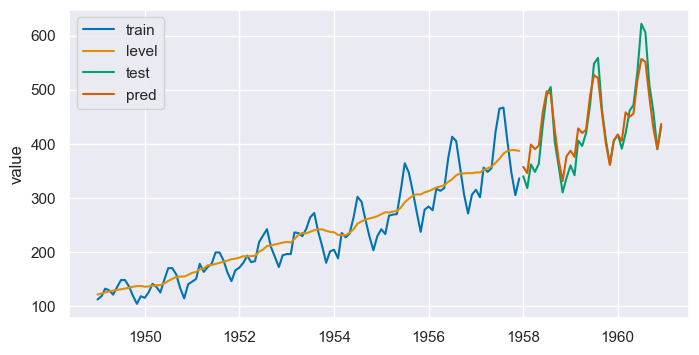

In [45]:
# 予測結果と季節調整済み系列の可視化
fig, ax = plot_series(train, hw_air.level, test, pred, 
                      labels=['train', 'level', 'test', 'pred'], 
                      markers=np.tile('', 4))
fig.set_size_inches(8, 4)

#### 乗法型のHolt-Winters法

In [46]:
# 乗法型としてモデル化
hw_air_mul = tsa.ExponentialSmoothing(
    train, trend='add', seasonal='mul', seasonal_periods=12).fit()

# 予測
pred_mul = hw_air_mul.forecast(len(test))

# 予測精度
mean_absolute_error(test, pred_mul)

22.318015069498156

### sktimeによる実践的な指数平滑化法

#### sktimeの利用

In [47]:
# 予測手法の指定
hw_forecaster = ExponentialSmoothing(trend='add', seasonal='add')

# データへの当てはめ
hw_forecaster.fit(train)

# 予測の実施
hw_fore_sk = hw_forecaster.predict(fh)

In [48]:
# 参考：statsmodelと同じ結果になる
np.sum((hw_fore_sk.value - pred) ** 2)

0.0

#### 精度の高い手法の探索

In [49]:
# 前処理から予測の選択までを1つのパイプラインにまとめる
pipe = TransformedTargetForecaster(
    steps=[
        ('log', OptionalPassthrough(LogTransformer())),
        ('forecaster', MultiplexForecaster(
            forecasters=[
                ('add', ExponentialSmoothing(trend='add', seasonal='add')),
                ('add_damped', ExponentialSmoothing(
                    trend='add', seasonal='add', damped_trend=True)),
                ('mul', ExponentialSmoothing(trend='add', seasonal='mul')),
                ('mul_damped', ExponentialSmoothing(
                    trend='add', seasonal='mul', damped_trend=True))
            ]
        )),
    ]
)

# 対数変換の有無・対象となる予測方法の一覧
param_grid = {
    'log__passthrough': [True, False],
    'forecaster__selected_forecaster': [
        'add', 'add_damped', 'mul', 'mul_damped'
    ],
}

# 12時点先予測のCVによってモデルの精度を比較して、最も精度が高い手法を選ぶ
cv = ExpandingWindowSplitter(
    fh=np.arange(1,13), initial_window=24, step_length=12
)

# 予測器の作成
cv_pipe_forecaster = ForecastingGridSearchCV(
    forecaster=pipe, param_grid=param_grid, 
    cv=cv, scoring=MeanAbsoluteError()
)

In [50]:
# データへの当てはめ
cv_pipe_forecaster.fit(train)

# CVで判断された最良の予測手法
cv_pipe_forecaster.best_params_

{'forecaster__selected_forecaster': 'add', 'log__passthrough': False}

In [51]:
# 参考：全ての方式のCVの結果一覧

# CVの結果のうち、必要な列だけをコピーする
result_df = cv_pipe_forecaster.cv_results_[
    ['mean_test_MeanAbsoluteError', 'params']].copy()

# パラメータの値だけを取り出して格納する
result_df['params'] = result_df['params'].apply(lambda x: list(x.values()))

# 結果の確認
print(result_df)

   mean_test_MeanAbsoluteError               params
0                    15.946600          [add, True]
1                     9.778336         [add, False]
2                    16.988803   [add_damped, True]
3                    11.627914  [add_damped, False]
4                    11.289958          [mul, True]
5                    10.083780         [mul, False]
6                    13.031329   [mul_damped, True]
7                    11.001232  [mul_damped, False]


In [52]:
# 予測の実施
best_pred = cv_pipe_forecaster.predict(fh)

# 予測精度
mean_absolute_error(test, best_pred)

32.86696975874994

### 指数平滑化法と状態空間モデル

### statsmodelsによる実装

In [53]:
# モデル化
hw_ssm = tsa.ETSModel(
    train['value'], error='add', trend="add", seasonal="add",
    damped_trend=False, seasonal_periods=12).fit()

# 予測
pred_hw_ssm = hw_ssm.forecast(len(test))

# 予測精度
mean_absolute_error(test, pred_hw_ssm)

21.502929501798196